In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys
from sklearn.metrics import r2_score

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
passivedecodingfilename = 'D:\\stimdecoding_25s_passive.csv'
choicedecodingfilename = 'D:\\choicedecoding.csv'

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
STIM_COLOR = '#E8CA17'
CHOICE_COLOR = '#9DE817'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stim25sdecodingfilename = 'D:\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = 'D:\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = 'D:\\stimdecoding_25s_opsin_off.csv'

current_version = 0 #June 22nd, 2023
current_version = 1 #June 29nd, 2023
current_version = 2 #July 27nd, 2023
current_version = 3 #August 12th, 2023
current_version = 4 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

# Load Data

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))

In [3]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


Fetching files for AE_240
Fetching files for AE_267
Fetching files for AO_273
Fetching files for AO_274
Fetching files for AE_287
Fetching files for AE_301
Fetching files for AE_312
P:\Behavioor\BS_61\behavior\BS_61_42v2_reversal.txt: No columns to parse from file
P:\Behavioor\BS_103\behavior\BS_103_11v4_opto.txt: No columns to parse from file
Error loading P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
P:\Behavioor\BS_123\behavior\BS_123_18v1_opto.txt: No columns to parse from file
ERROR: MULTIPLE REVERSALS IN ANIMAL BS_179
P:\Behavioor\BS_191\behavior\BS_191_1v2.txt: No columns to parse from file
Error loading P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_9v1.txt: No columns to parse from file
P:\Behavioor\BS_33\behavior\BS_33_20v1_reversal.txt: No columns to parse from file
P:\Behavioor\BS_49\behavior\BS_49_14v4_reversal.txt: No columns to parse from file
Error loading P:\Behavioor\BS_87\b

../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scalars
  pc = (hit+creject)/(hit+miss+falarm+creject)
../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in long_scala

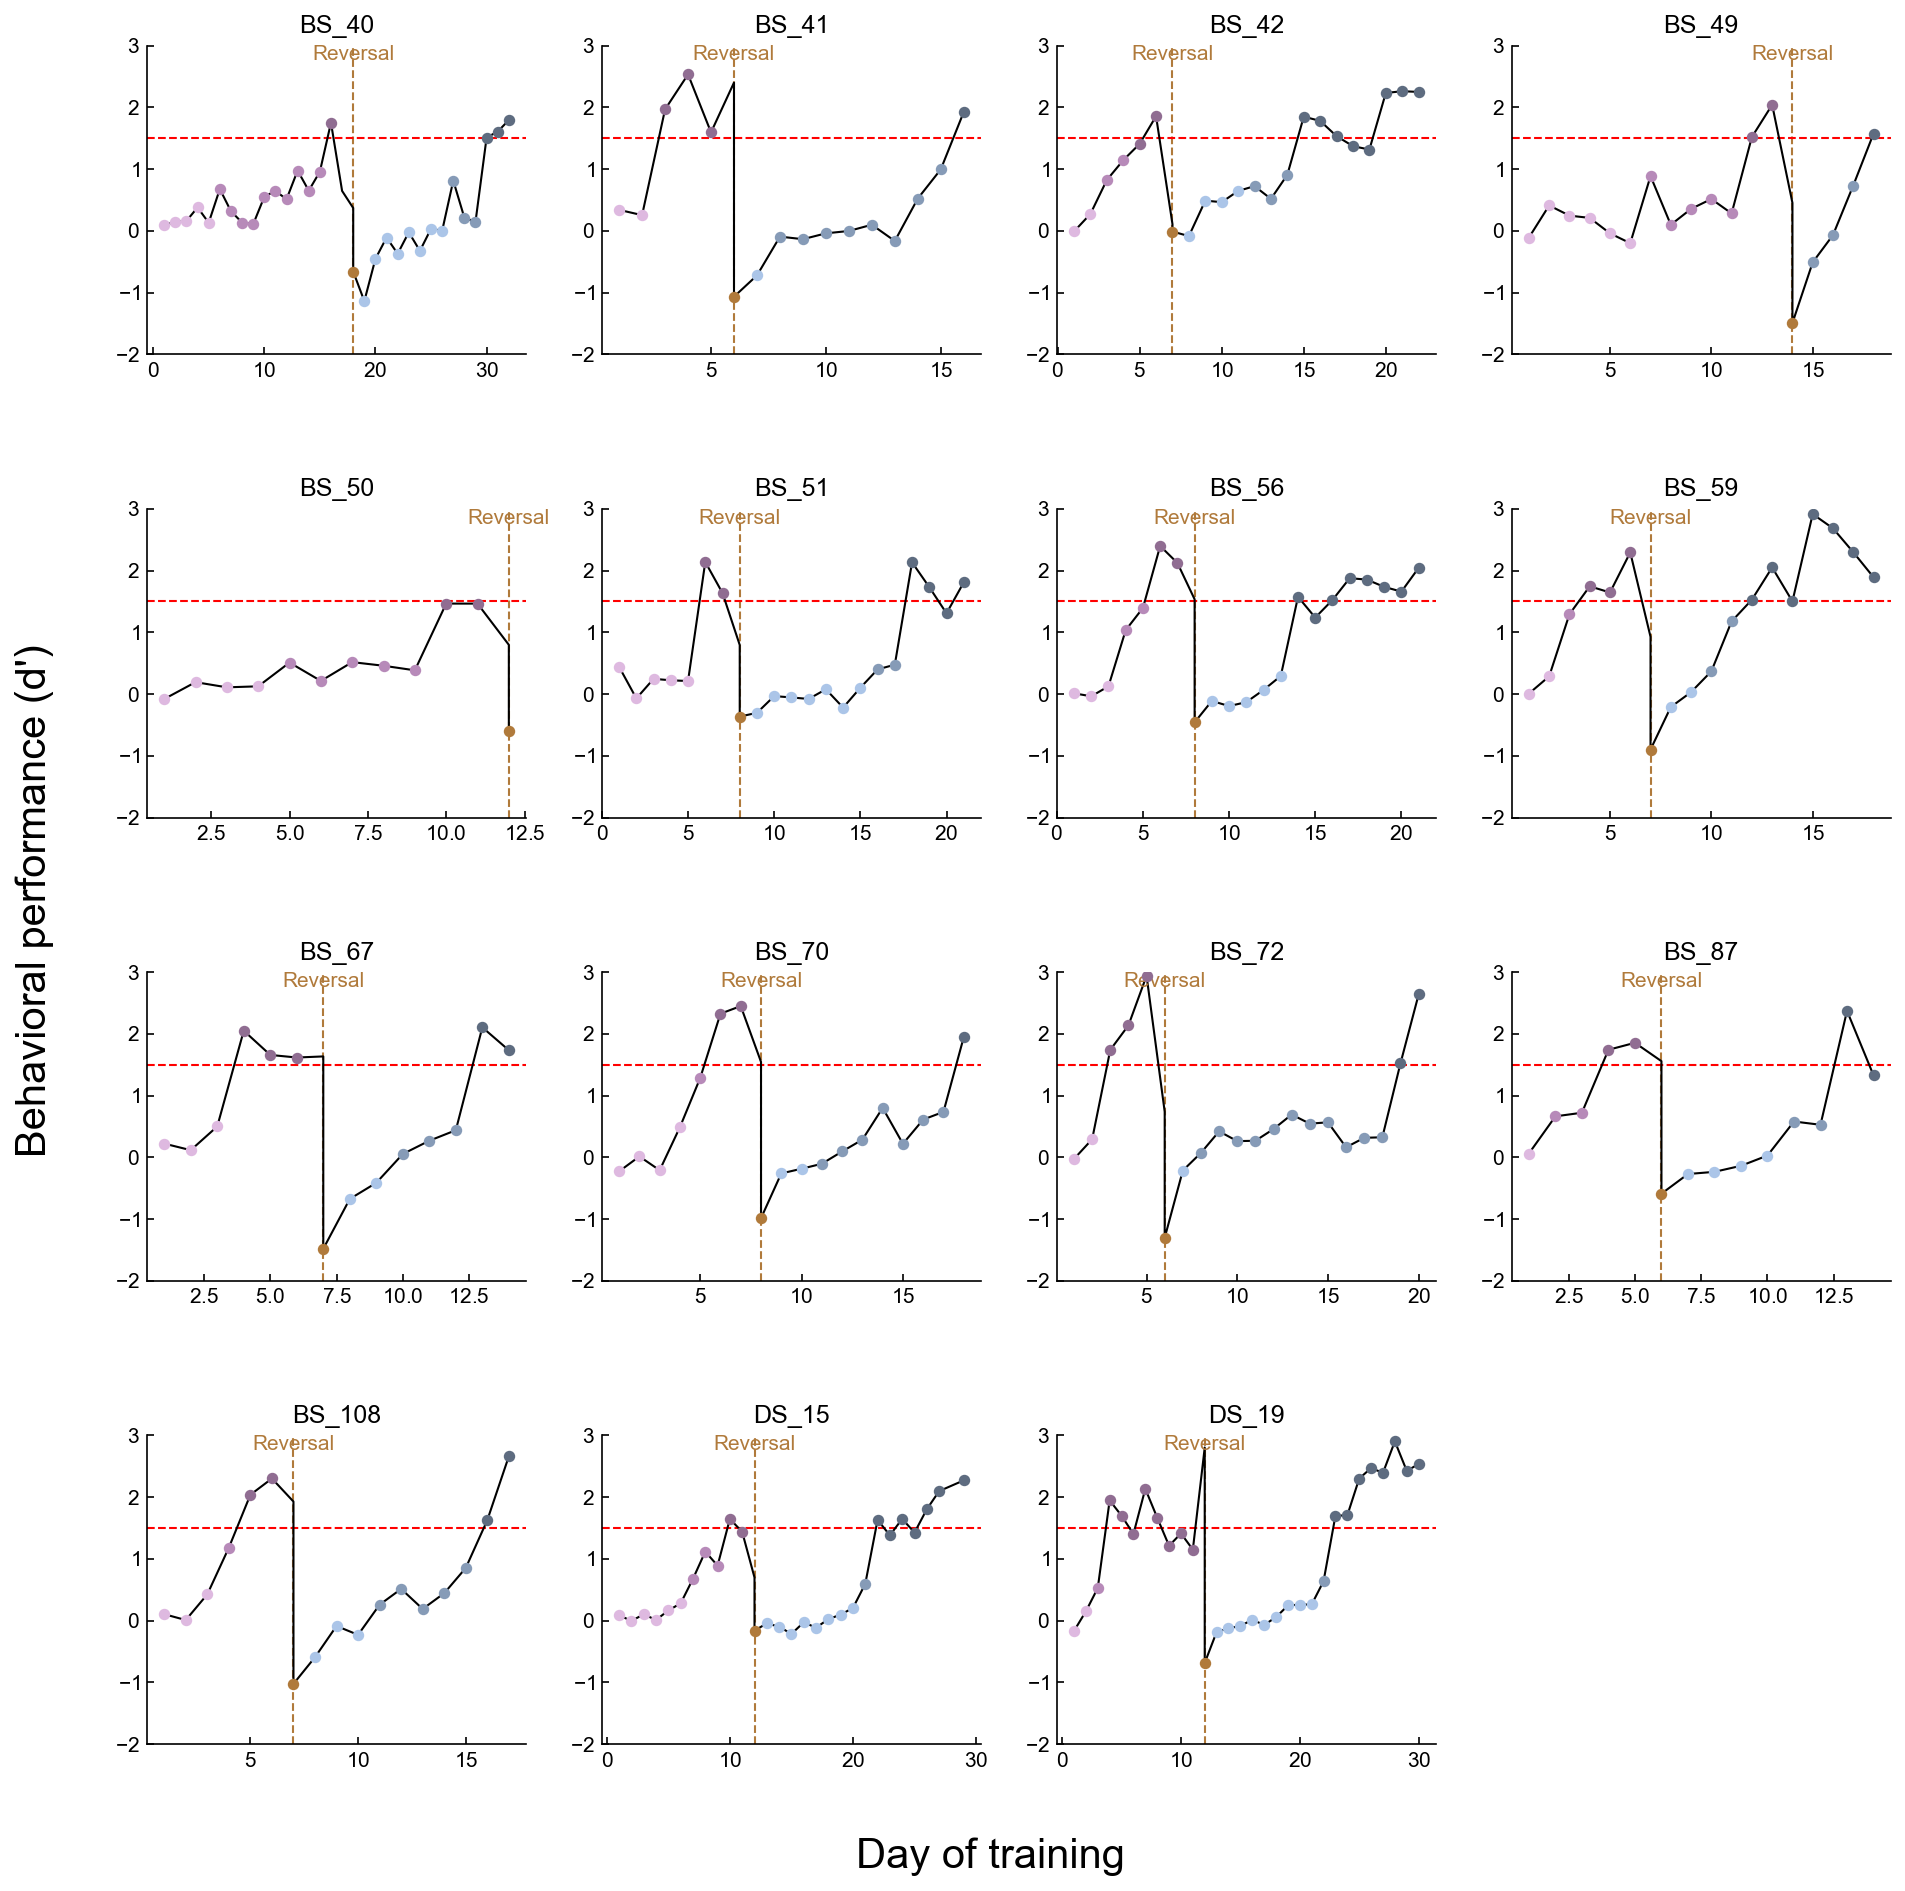

In [4]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [5]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no beahvior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:09<00:00, 74.76it/s] 


In [6]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:37<00:00, 49.24it/s] 

errors for: []


# Load Decoding

In [7]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,choice_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [8]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
#     pvalue_stim_c = getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
#     pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
#     pval_stim_c.append(pvalue_stim_c)
#     pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
# pval_stim_c = np.array(pval_stim_c)
# pval_choice_c = np.array(pval_choice_c)

1829it [00:08, 219.75it/s]


In [9]:
def get_TE_mask(acc,pval_s,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    is_valid_pval = np.less(pval_s,0.05) #np.less(pval_c,0.05))
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s,pval_stim_c)
_,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s,pval_choice_c)

Task encoder threshold: 0.55951845
Task encoder threshold: 0.5841134751773049


In [10]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# Ramping_preearly = []
# Ramping_prelate = []
# Ramping_preexpert = []
# Ramping_postearly = []
# Ramping_postlate = []
# Ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(FRmod)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(FRmod)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(FRmod)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(FRmod)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(FRmod)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(FRmod)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

1829it [00:37, 48.70it/s] 


In [11]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
choice_df = pd.read_csv(choicedecodingfilename)
dec_df = pd.concat([stim_25s_df,passive_df,choice_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [12]:
Stim_Dec_preearly = []
Stim_Dec_prelate = []
Stim_Dec_preexpert = []
Stim_Dec_postearly = []
Stim_Dec_postlate = []
Stim_Dec_postexpert = []

# Choice_Dec_preearly = []
# Choice_Dec_prelate = []
# Choice_Dec_preexpert = []
# Choice_Dec_postearly = []
# Choice_Dec_postlate = []
# Choice_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
#     if getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
#         stim_acc = np.nan
#     if getDataPoint(dec_df,session,clust,'response','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
#         choice_acc = np.nan
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    if EILphases[idx] == 'pre early':
        Stim_Dec_preearly.append(stim_acc)
#         Choice_Dec_preearly.append(choice_acc)
    elif EILphases[idx] == 'pre late':
        Stim_Dec_prelate.append(stim_acc)
#         Choice_Dec_prelate.append(choice_acc)
    elif EILphases[idx] == 'pre expert':
        Stim_Dec_preexpert.append(stim_acc)
#         Choice_Dec_preexpert.append(choice_acc)
    elif EILphases[idx] == 'post early':
        Stim_Dec_postearly.append(stim_acc)
#         Choice_Dec_postearly.append(choice_acc)
    elif EILphases[idx] == 'post late':
        Stim_Dec_postlate.append(stim_acc)
#         Choice_Dec_postlate.append(choice_acc)
    elif EILphases[idx] == 'post expert':
        Stim_Dec_postexpert.append(stim_acc)
#         Choice_Dec_postexpert.append(choice_acc)
        
Stim_Dec_preearly = np.array(Stim_Dec_preearly)
Stim_Dec_prelate = np.array(Stim_Dec_prelate)
Stim_Dec_preexpert = np.array(Stim_Dec_preexpert)
Stim_Dec_postearly = np.array(Stim_Dec_postearly)
Stim_Dec_postlate = np.array(Stim_Dec_postlate)
Stim_Dec_postexpert = np.array(Stim_Dec_postexpert)

# Choice_Dec_preearly = np.array(Choice_Dec_preearly)
# Choice_Dec_prelate = np.array(Choice_Dec_prelate)
# Choice_Dec_preexpert = np.array(Choice_Dec_preexpert)
# Choice_Dec_postearly = np.array(Choice_Dec_postearly)
# Choice_Dec_postlate = np.array(Choice_Dec_postlate)
# Choice_Dec_postexpert = np.array(Choice_Dec_postexpert)

1829it [00:46, 39.56it/s]


In [14]:
FRmod = np.concatenate((FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert))
# Ramping = np.concatenate((Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert))

stim_acc = np.concatenate((Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert))
# choice_acc = np.concatenate((Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert))

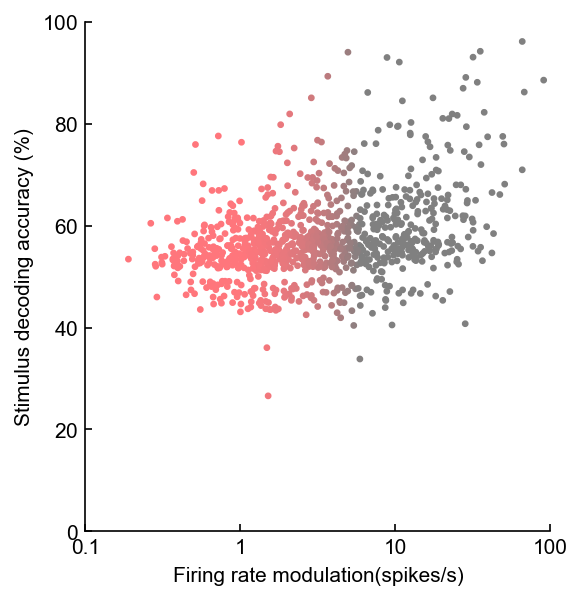

In [50]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(FRmod,stim_acc*100,c=NCR_CR_cmap((FRmod-1)/5),s=5)
ax.set_xscale('log',subs=[])
ax.set_xlim([0.1,100])
ax.set_xticks([0.1,1,10,100])
ax.set_xticklabels(['0.1','1','10','100'])
ax.set_xlabel('Firing rate modulation(spikes/s)')

ax.set_ylim([0,100])
ax.set_ylabel('Stimulus decoding accuracy (%)')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC FRmodulation vs decoding V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [48]:
X,Y = ilep.paired_rmnan(FRmod,stim_acc*100)
pearsonr(X,Y)

(0.4025872924091249, 9.29843262719201e-42)

In [76]:
FRmod = np.concatenate((FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert))
stim_acc = np.concatenate((Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert))

is_TE = np.greater_equal(stim_acc,task_encoder_threshold_s)

FRmod_TEs = FRmod[is_TE]
FRmod_nonTEs = FRmod[np.logical_not(is_TE)]

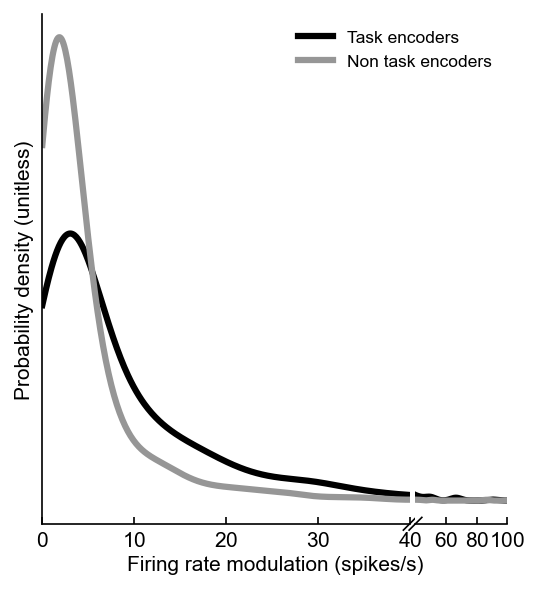

In [119]:
fig = plt.figure(figsize=(4,4.5))
bax = brokenaxes(xlims=( (0,40), (40, 100) ), width_ratios=[4,1], wspace=0.025)
x_range = np.linspace(0,100,1000)

KDE = gaussian_kde(ilep.rmnan(FRmod_TEs), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
bax.plot(x_range,KDE_eval,color='k',lw=3,label='Task encoders')

KDE = gaussian_kde(ilep.rmnan(FRmod_nonTEs), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
bax.plot(x_range,KDE_eval,color=GOOD_GREY,lw=3,label='Non task encoders')

bax.axs[0].set_xticks([0,10,20,30,40])
bax.axs[1].set_xticks([60,80,100])

t1 = bax.set_xlabel('Firing rate modulation (spikes/s)')
t2 = bax.axs[0].set_ylabel('Probability density (unitless)')
bax.axs[0].set_yticks([])

bax.legend(frameon=False,loc='upper right')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC FRmodulation distribution TE vs nTE V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [121]:
X = ilep.rmnan(FRmod_TEs)
Y = ilep.rmnan(FRmod_nonTEs)
mannwhitneyu(X,Y).pvalue

8.518828202293384e-24

In [97]:
FRmod = np.concatenate((FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert))
stim_acc = np.concatenate((Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert))

is_CR = np.greater_equal(FRmod,3.5)

stim_acc_CR = stim_acc[is_CR]*100
stim_acc_NCR = stim_acc[np.logical_not(is_CR)]*100

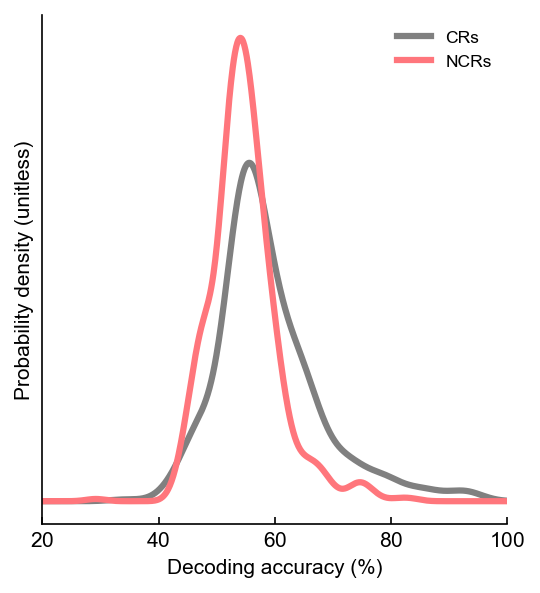

In [118]:
fig, ax = plt.subplots(figsize=(4,4.5))
x_range = np.linspace(0,100,1000)

KDE = gaussian_kde(ilep.rmnan(stim_acc_CR), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
ax.plot(x_range,KDE_eval,color=CR_COLOR,lw=3,label='CRs')

KDE = gaussian_kde(ilep.rmnan(stim_acc_NCR), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
ax.plot(x_range,KDE_eval,color=NCR_COLOR,lw=3,label='NCRs')

ax.set_xlim([20,100])
t1 = ax.set_xlabel('Decoding accuracy (%)')

t2 = ax.set_ylabel('Probability density (unitless)')
ax.set_yticks([])

ax.legend(frameon=False,loc='upper right')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Decoding distribution CR vs NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [122]:
X = ilep.rmnan(stim_acc_CR)
Y = ilep.rmnan(stim_acc_NCR)
mannwhitneyu(X,Y).pvalue

5.43977951867984e-18

# Up-Ramping cells

In [143]:
Ramping_preearly = []
Ramping_prelate = []
Ramping_preexpert = []
Ramping_postearly = []
Ramping_postlate = []
Ramping_postexpert = []

RampingNorm_preearly = []
RampingNorm_prelate = []
RampingNorm_preexpert = []
RampingNorm_postearly = []
RampingNorm_postlate = []
RampingNorm_postexpert = []

cellstouseFR = 'all cells'
#cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(accuracies[idx]) or pvals[idx] > 0.05 or accuracies[idx] < task_encoder_threshold:
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
    if rampingMod <= 0:
        continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_preearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre late':
        Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_prelate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'pre expert':
        Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post early':
        Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_postearly.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post late':
        Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_postlate.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)
    elif EILphases[idx] == 'post expert':
        Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        RampingNorm_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingModNorm)

RampingNorm_preearly = np.array(RampingNorm_preearly)
RampingNorm_prelate = np.array(RampingNorm_prelate)
RampingNorm_preexpert = np.array(RampingNorm_preexpert)
RampingNorm_postearly = np.array(RampingNorm_postearly)
RampingNorm_postlate = np.array(RampingNorm_postlate)
RampingNorm_postexpert = np.array(RampingNorm_postexpert)

RampingNorm_preearly = np.array(RampingNorm_preearly)
RampingNorm_prelate = np.array(RampingNorm_prelate)
RampingNorm_preexpert = np.array(RampingNorm_preexpert)
RampingNorm_postearly = np.array(RampingNorm_postearly)
RampingNorm_postlate = np.array(RampingNorm_postlate)
RampingNorm_postexpert = np.array(RampingNorm_postexpert)

1682it [00:20, 80.25it/s] 


In [127]:
# Stim_Dec_preearly = []
# Stim_Dec_prelate = []
# Stim_Dec_preexpert = []
# Stim_Dec_postearly = []
# Stim_Dec_postlate = []
# Stim_Dec_postexpert = []

Choice_Dec_preearly = []
Choice_Dec_prelate = []
Choice_Dec_preexpert = []
Choice_Dec_postearly = []
Choice_Dec_postlate = []
Choice_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
#     if getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
#         stim_acc = np.nan
#     if getDataPoint(dec_df,session,clust,'response','pval_shuffled_control') > 0.05 or getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
#         choice_acc = np.nan
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    rampingMod = sessionfile.responsiveness[clust]['go'].rampingMod
    if rampingMod <= 0:
        continue
    
    if EILphases[idx] == 'pre early':
#         Stim_Dec_preearly.append(stim_acc)
        Choice_Dec_preearly.append(choice_acc)
    elif EILphases[idx] == 'pre late':
#         Stim_Dec_prelate.append(stim_acc)
        Choice_Dec_prelate.append(choice_acc)
    elif EILphases[idx] == 'pre expert':
#         Stim_Dec_preexpert.append(stim_acc)
        Choice_Dec_preexpert.append(choice_acc)
    elif EILphases[idx] == 'post early':
#         Stim_Dec_postearly.append(stim_acc)
        Choice_Dec_postearly.append(choice_acc)
    elif EILphases[idx] == 'post late':
#         Stim_Dec_postlate.append(stim_acc)
        Choice_Dec_postlate.append(choice_acc)
    elif EILphases[idx] == 'post expert':
#         Stim_Dec_postexpert.append(stim_acc)
        Choice_Dec_postexpert.append(choice_acc)
        
# Stim_Dec_preearly = np.array(Stim_Dec_preearly)
# Stim_Dec_prelate = np.array(Stim_Dec_prelate)
# Stim_Dec_preexpert = np.array(Stim_Dec_preexpert)
# Stim_Dec_postearly = np.array(Stim_Dec_postearly)
# Stim_Dec_postlate = np.array(Stim_Dec_postlate)
# Stim_Dec_postexpert = np.array(Stim_Dec_postexpert)

Choice_Dec_preearly = np.array(Choice_Dec_preearly)
Choice_Dec_prelate = np.array(Choice_Dec_prelate)
Choice_Dec_preexpert = np.array(Choice_Dec_preexpert)
Choice_Dec_postearly = np.array(Choice_Dec_postearly)
Choice_Dec_postlate = np.array(Choice_Dec_postlate)
Choice_Dec_postexpert = np.array(Choice_Dec_postexpert)

1682it [00:28, 59.21it/s] 


In [54]:
# FRmod = np.concatenate((FRmod_preearly,FRmod_prelate,FRmod_preexpert,FRmod_postearly,FRmod_postlate,FRmod_postexpert))
Ramping = np.concatenate((Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert))

# stim_acc = np.concatenate((Stim_Dec_preearly,Stim_Dec_prelate,Stim_Dec_preexpert,Stim_Dec_postearly,Stim_Dec_postlate,Stim_Dec_postexpert))
choice_acc = np.concatenate((Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert))

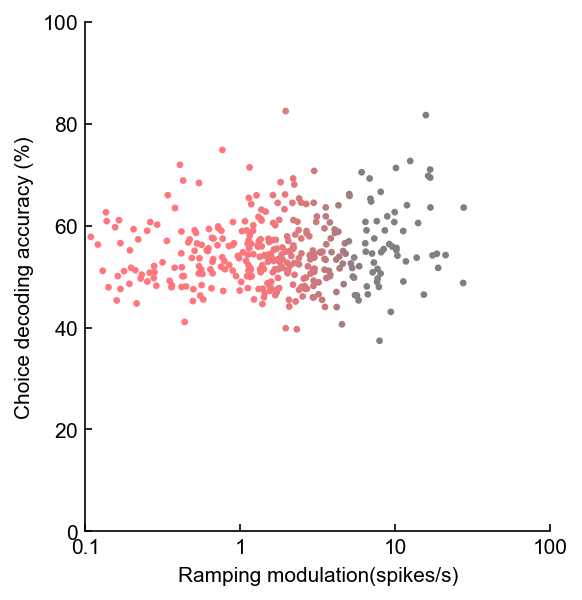

In [55]:
fig, ax = plt.subplots(figsize=(4,4.5))

ax.scatter(Ramping,choice_acc*100,c=NCR_CR_cmap((Ramping-1)/5),s=5)
ax.set_xscale('log',subs=[])
ax.set_xlim([0.1,100])
ax.set_xticks([0.1,1,10,100])
ax.set_xticklabels(['0.1','1','10','100'])
ax.set_xlabel('Ramping modulation(spikes/s)')

ax.set_ylim([0,100])
ax.set_ylabel('Choice decoding accuracy (%)')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Ramping vs decoding V'+str(current_version)+'.pdf'),transparent=False,facecolor="white")

In [56]:
X,Y = ilep.paired_rmnan(Ramping,choice_acc*100)
pearsonr(X,Y)

(0.16243137817430708, 0.001599746899886223)

In [138]:
Ramping = np.concatenate((Ramping_preearly,Ramping_prelate,Ramping_preexpert,Ramping_postearly,Ramping_postlate,Ramping_postexpert))
choice_acc = np.concatenate((Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert))

is_TE = np.greater_equal(choice_acc,task_encoder_threshold_c)

Ramping_TEs = Ramping[is_TE]
Ramping_nonTEs = Ramping[np.logical_not(is_TE)]

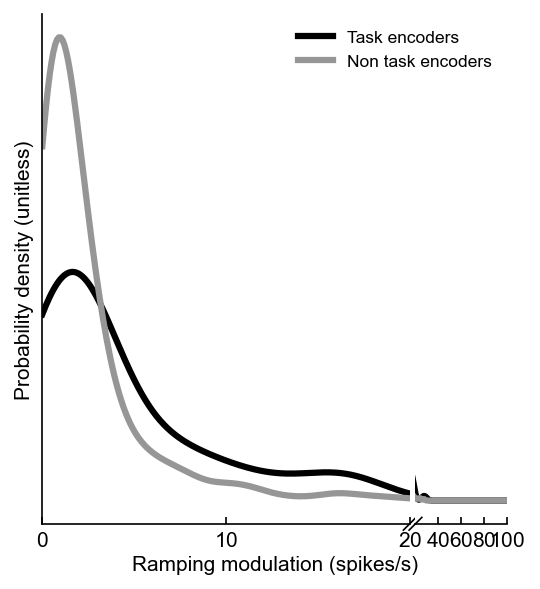

In [141]:
fig = plt.figure(figsize=(4,4.5))
bax = brokenaxes(xlims=( (0,20), (20, 100) ), width_ratios=[4,1], wspace=0.025)
x_range = np.linspace(0,100,1000)

KDE = gaussian_kde(ilep.rmnan(Ramping_TEs), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
bax.plot(x_range,KDE_eval,color='k',lw=3,label='Task encoders')

KDE = gaussian_kde(ilep.rmnan(Ramping_nonTEs), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
bax.plot(x_range,KDE_eval,color=GOOD_GREY,lw=3,label='Non task encoders')

bax.axs[0].set_xticks([0,10,20])
bax.axs[1].set_xticks([40,60,80,100])

t1 = bax.set_xlabel('Ramping modulation (spikes/s)')
t2 = bax.axs[0].set_ylabel('Probability density (unitless)')
bax.axs[0].set_yticks([])

bax.legend(frameon=False,loc='upper right')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Ramping distribution TE vs nTE V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [142]:
X = ilep.rmnan(Ramping_TEs)
Y = ilep.rmnan(Ramping_nonTEs)
mannwhitneyu(X,Y).pvalue

0.000570489214385169

In [147]:
RampingNorm = np.concatenate((RampingNorm_preearly,RampingNorm_prelate,RampingNorm_preexpert,RampingNorm_postearly,RampingNorm_postlate,RampingNorm_postexpert))
choice_acc = np.concatenate((Choice_Dec_preearly,Choice_Dec_prelate,Choice_Dec_preexpert,Choice_Dec_postearly,Choice_Dec_postlate,Choice_Dec_postexpert))

is_Ramp = np.greater_equal(RampingNorm,0.5)

choice_acc_ramping = choice_acc[is_Ramp]*100
choice_acc_nonramping = choice_acc[np.logical_not(is_Ramp)]*100

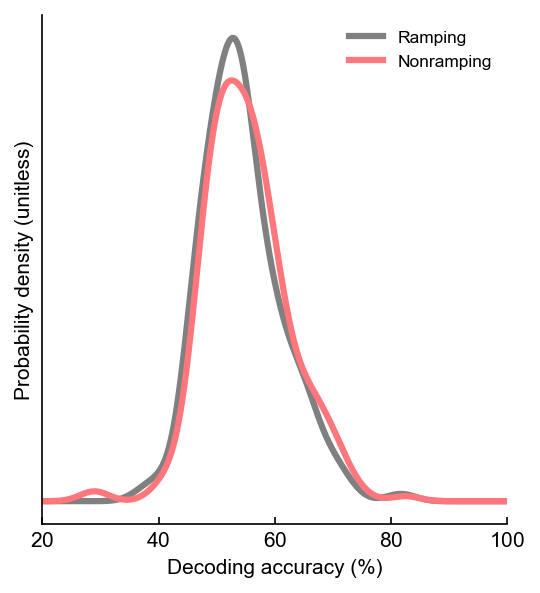

In [152]:
fig, ax = plt.subplots(figsize=(4,4.5))
x_range = np.linspace(0,100,1000)

KDE = gaussian_kde(ilep.rmnan(choice_acc_ramping), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
ax.plot(x_range,KDE_eval,color=CR_COLOR,lw=3,label='Ramping')

KDE = gaussian_kde(ilep.rmnan(choice_acc_nonramping), bw_method='scott')
KDE_eval = KDE.evaluate(x_range)
#KDE_eval = np.cumsum(KDE_eval) / np.sum(KDE_eval)
ax.plot(x_range,KDE_eval,color=NCR_COLOR,lw=3,label='Nonramping')

ax.set_xlim([20,100])
t1 = ax.set_xlabel('Decoding accuracy (%)')

t2 = ax.set_ylabel('Probability density (unitless)')
ax.set_yticks([])

ax.legend(frameon=False,loc='upper right')

fig.savefig(os.path.join('D:\\\\Figures','Automated Behavior Figures','AC Choice decoding distribution Ramping vs Nonramping V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(t1,t2), bbox_inches='tight')

In [151]:
X = ilep.rmnan(choice_acc_ramping)
Y = ilep.rmnan(choice_acc_nonramping)
mannwhitneyu(X,Y).pvalue

0.1875195898288513

In [16]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1829it [00:08, 205.37it/s]


In [17]:
FRmod_preearly = []
FRmod_prelate = []
FRmod_preexpert = []
FRmod_postearly = []
FRmod_postlate = []
FRmod_postexpert = []

# Ramping_preearly = []
# Ramping_prelate = []
# Ramping_preexpert = []
# Ramping_postearly = []
# Ramping_postlate = []
# Ramping_postexpert = []

preearly_animals = []
prelate_animals = []
preexpert_animals = []
postearly_animals = []
postlate_animals = []
postexpert_animals = []

#cellstouseFR = 'all cells'
cellstouseFR = 'task encoders'

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
            continue
        if np.isnan(stim_acc[idx]) or np.isnan(pval_stim_s[idx]):
            continue
        
    if sessionfile.responsiveness[clust]['all_trials'].FR < sessionfile.responsiveness[clust]['all_trials'].FRbaseline:
        #print('excluded')
        #continue
        pass
    
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    if EILphases[idx] == 'pre early':
        FRmod_preearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_preearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre late':
        FRmod_prelate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_prelate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        prelate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'pre expert':
        FRmod_preexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_preexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        preexpert_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post early':
        FRmod_postearly.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_postearly.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postearly_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post late':
        FRmod_postlate.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_postlate.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postlate_animals.append(sessionfile.meta.animal)
    elif EILphases[idx] == 'post expert':
        FRmod_postexpert.append(sessionfile.responsiveness[clust]['all_trials'].FRmodulation)
#         Ramping_postexpert.append(sessionfile.responsiveness[clust]['go'].rampingMod)
        postexpert_animals.append(sessionfile.meta.animal)

FRmod_preearly = np.array(FRmod_preearly)
FRmod_prelate = np.array(FRmod_prelate)
FRmod_preexpert = np.array(FRmod_preexpert)
FRmod_postearly = np.array(FRmod_postearly)
FRmod_postlate = np.array(FRmod_postlate)
FRmod_postexpert = np.array(FRmod_postexpert)

# Ramping_preearly = np.array(Ramping_preearly)
# Ramping_prelate = np.array(Ramping_prelate)
# Ramping_preexpert = np.array(Ramping_preexpert)
# Ramping_postearly = np.array(Ramping_postearly)
# Ramping_postlate = np.array(Ramping_postlate)
# Ramping_postexpert = np.array(Ramping_postexpert)

1829it [00:35, 51.69it/s] 


In [18]:
print(len(FRmod_preearly))
print(len(FRmod_prelate))
print(len(FRmod_preexpert))
print(len(FRmod_postearly))
print(len(FRmod_postlate))
print(len(FRmod_postexpert))

37
51
50
93
137
80


# Split by Learning Phases

In [19]:
CR_Stim_Dec_preearly = []
CR_Stim_Dec_prelate = []
CR_Stim_Dec_preexpert = []
CR_Stim_Dec_postearly = []
CR_Stim_Dec_postlate = []
CR_Stim_Dec_postexpert = []

NCR_Stim_Dec_preearly = []
NCR_Stim_Dec_prelate = []
NCR_Stim_Dec_preexpert = []
NCR_Stim_Dec_postearly = []
NCR_Stim_Dec_postlate = []
NCR_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
        continue
    if np.isnan(stim_acc[idx]) or np.isnan(pval_stim_s[idx]):
        continue
    
    tstim_acc = stim_acc[idx] #getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    tchoice_acc = stim_acc[idx] #getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
#     if not np.isfinite(getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05):
#         continue
#     if not np.isfinite(getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05):
#         continue
#     if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
#         stim_acc = np.nan
#         continue
#     if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
#         choice_acc = np.nan
#         continue
        
    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
    
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
#         FRmod = 0
        continue
       
#     if not is_TE_s[idx]:
#         continue
#     if stim_acc < task_encoder_threshold_s:
#         continue
    
    if EILphases[idx] == 'pre early':
        if FRmod >= 3.5:
            CR_Stim_Dec_preearly.append(tstim_acc)
        else:
            NCR_Stim_Dec_preearly.append(tstim_acc)
    elif EILphases[idx] == 'pre late':
        if FRmod >= 3.5:
            CR_Stim_Dec_prelate.append(tstim_acc)
        else:
            NCR_Stim_Dec_prelate.append(tstim_acc)
    elif EILphases[idx] == 'pre expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_preexpert.append(tstim_acc)
        else:
            NCR_Stim_Dec_preexpert.append(tstim_acc)
    elif EILphases[idx] == 'post early':
        if FRmod >= 3.5:
            CR_Stim_Dec_postearly.append(tstim_acc)
        else:
            NCR_Stim_Dec_postearly.append(tstim_acc)
    elif EILphases[idx] == 'post late':
        if FRmod >= 3.5:
            CR_Stim_Dec_postlate.append(tstim_acc)
        else:
            NCR_Stim_Dec_postlate.append(tstim_acc)
    elif EILphases[idx] == 'post expert':
        if FRmod >= 3.5:
            CR_Stim_Dec_postexpert.append(tstim_acc)
        else:
            NCR_Stim_Dec_postexpert.append(tstim_acc)
        
CR_Stim_Dec_preearly = (np.array(CR_Stim_Dec_preearly))
CR_Stim_Dec_prelate = (np.array(CR_Stim_Dec_prelate))
CR_Stim_Dec_preexpert = (np.array(CR_Stim_Dec_preexpert))
CR_Stim_Dec_postearly = (np.array(CR_Stim_Dec_postearly))
CR_Stim_Dec_postlate = (np.array(CR_Stim_Dec_postlate))
CR_Stim_Dec_postexpert = (np.array(CR_Stim_Dec_postexpert))

NCR_Stim_Dec_preearly = (np.array(NCR_Stim_Dec_preearly))
NCR_Stim_Dec_prelate = (np.array(NCR_Stim_Dec_prelate))
NCR_Stim_Dec_preexpert = (np.array(NCR_Stim_Dec_preexpert))
NCR_Stim_Dec_postearly = (np.array(NCR_Stim_Dec_postearly))
NCR_Stim_Dec_postlate = (np.array(NCR_Stim_Dec_postlate))
NCR_Stim_Dec_postexpert = (np.array(NCR_Stim_Dec_postexpert))

1829it [00:34, 52.52it/s] 


### V1

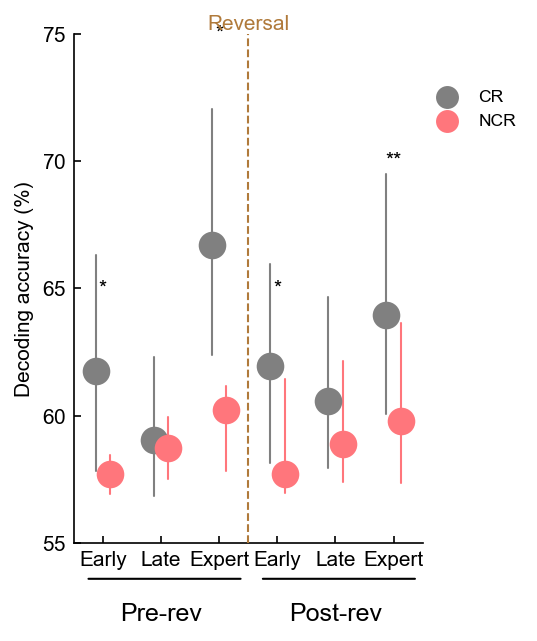

In [25]:
labels = ['Early','Late','Expert','Early','Late','Expert']

fig, ax = plt.subplots(figsize=(3,4.5))
    
for idx,(CR_Stim_Dec) in enumerate([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-0.125]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


for idx,(NCR_Stim_Dec) in enumerate([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+0.125], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+0.125]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.set_xlim([-0.5,5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels)

ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ax.set_ylabel('Decoding accuracy (%)')

ax.text(0,65,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(1,65,str(''),verticalalignment='center',horizontalalignment='center')
ax.text(2,75,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(3,65,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(4,65,str(''),verticalalignment='center',horizontalalignment='center')
ax.text(5,70,str('**'),verticalalignment='center',horizontalalignment='center')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.15
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[], ec=CR_COLOR,fc=CR_COLOR, s=100,lw=1, zorder=10,label='CR')
ax.scatter([],[], ec=NCR_COLOR,fc=NCR_COLOR, s=100,lw=1, zorder=10,label='NCR')
lgd = ax.legend(frameon=False,loc=(1,0.8))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

### V2

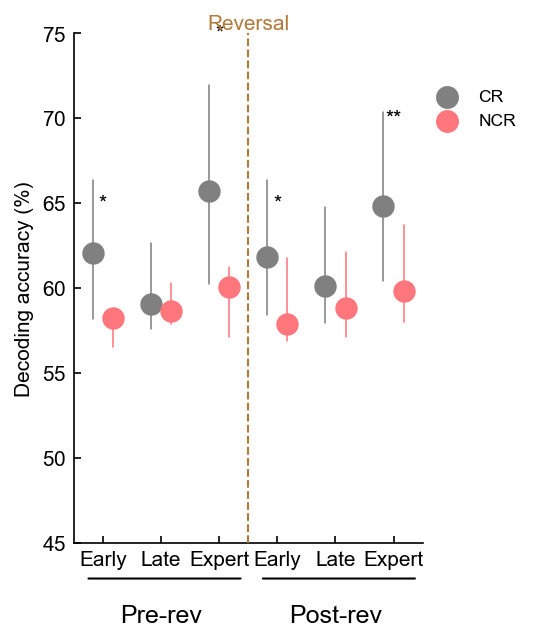

In [14]:
labels = ['Early','Late','Expert','Early','Late','Expert']

fig, ax = plt.subplots(figsize=(3,4.5))
wid = 0.175
    
for idx,(CR_Stim_Dec) in enumerate([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-wid]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


for idx,(NCR_Stim_Dec) in enumerate([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.set_xlim([-0.5,5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels)

ax.set_ylim([45,75])
ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylabel('Decoding accuracy (%)')

ax.text(0,65,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(1,65,str(''),verticalalignment='center',horizontalalignment='center')
ax.text(2,75,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(3,65,str('*'),verticalalignment='center',horizontalalignment='center')
ax.text(4,65,str(''),verticalalignment='center',horizontalalignment='center')
ax.text(5,70,str('**'),verticalalignment='center',horizontalalignment='center')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.15
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[], ec=CR_COLOR,fc=CR_COLOR, s=100,lw=1, zorder=10,label='CR')
ax.scatter([],[], ec=NCR_COLOR,fc=NCR_COLOR, s=100,lw=1, zorder=10,label='NCR')
lgd = ax.legend(frameon=False,loc=(1,0.8))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

### V3

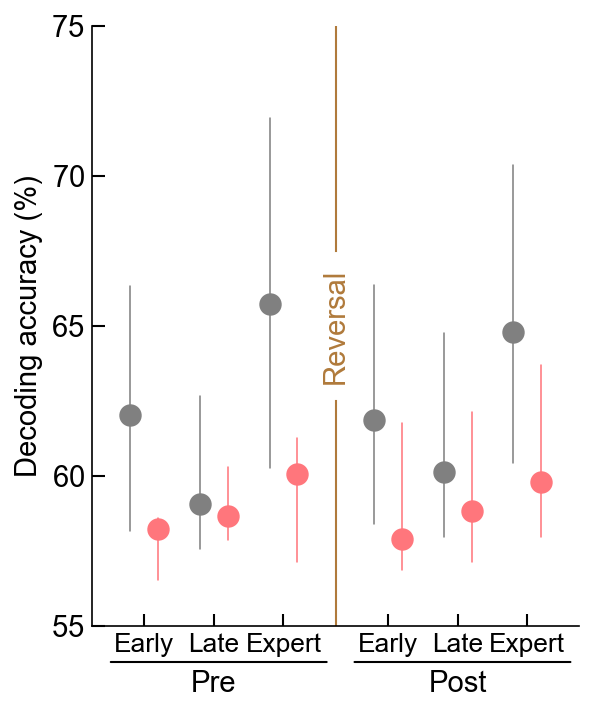

In [16]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
wid = 0.2

################################################################################################################

for idx,(CR_Stim_Dec,p) in enumerate(zip([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+-wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

for idx,(NCR_Stim_Dec,p) in enumerate(zip([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

# ax.set_ylim([45,75])
# ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ylab = ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

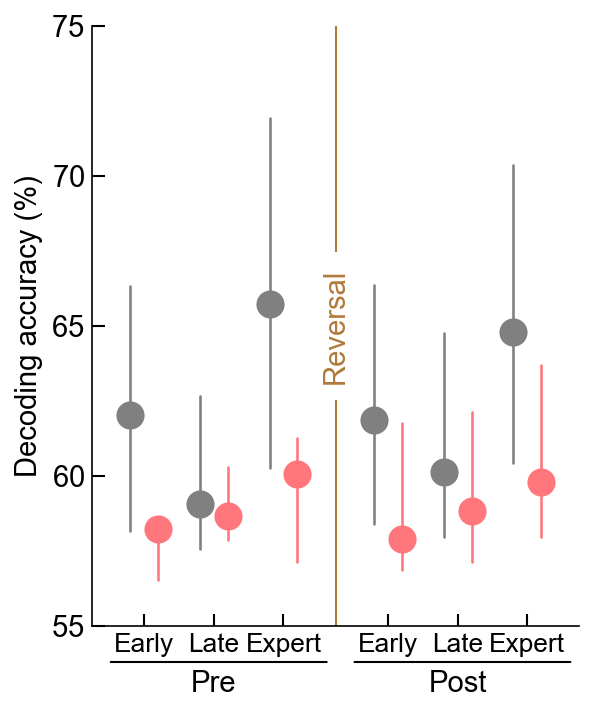

In [30]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(3.25, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.25
wid = 0.2

################################################################################################################

for idx,(CR_Stim_Dec,p) in enumerate(zip([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+-wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

for idx,(NCR_Stim_Dec,p) in enumerate(zip([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

# ax.set_ylim([45,75])
# ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ylab = ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

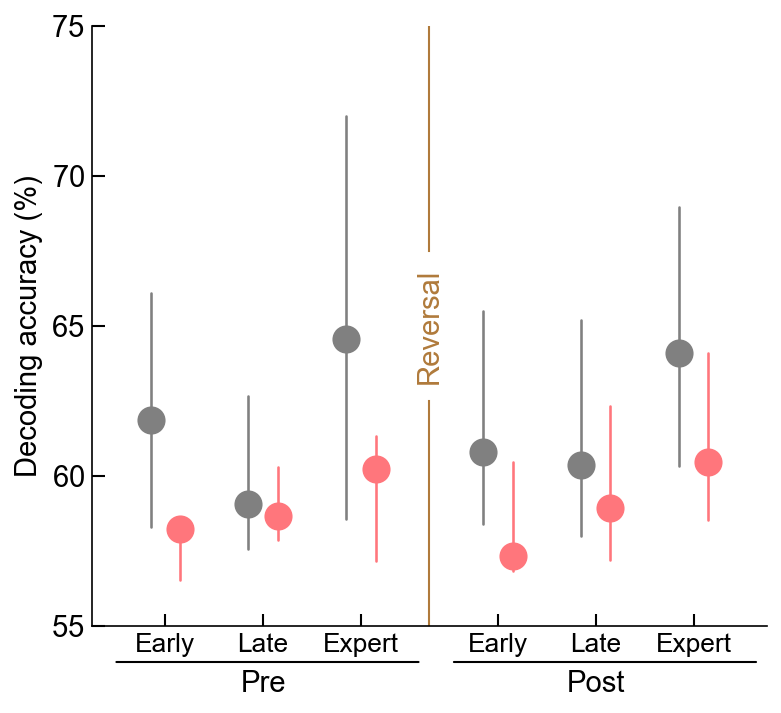

In [27]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(4.5, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2
wid = 0.15

################################################################################################################

for idx,(CR_Stim_Dec,p) in enumerate(zip([CR_Stim_Dec_preearly,CR_Stim_Dec_prelate,CR_Stim_Dec_preexpert,CR_Stim_Dec_postearly,CR_Stim_Dec_postlate,CR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+-wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

for idx,(NCR_Stim_Dec,p) in enumerate(zip([NCR_Stim_Dec_preearly,NCR_Stim_Dec_prelate,NCR_Stim_Dec_preexpert,NCR_Stim_Dec_postearly,NCR_Stim_Dec_postlate,NCR_Stim_Dec_postexpert],[-1,-1,-1,1,1,1])):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=150
    summary_width=1.25
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid+p*switch_offset], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid+p*switch_offset]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

################################################################################################################
labels = ['Early','Late','Expert','Early','Late','Expert']

# ax.set_ylim([45,75])
# ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylim([55,75])
ax.set_yticks([55,60,65,70,75])
ylab = ax.set_ylabel('Decoding accuracy (%)')

ax.set_xlim([-0.75-switch_offset,5.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset,3+switch_offset,4+switch_offset,5+switch_offset])
ax.set_xticklabels(labels)
# xlab = ax.set_xlabel('Example X label')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac,log=False)
t1 = ax.text(xtick_pos_pre, Yval, 'Pre', ha='center', va='bottom', fontsize=stdfont,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post', ha='center', va='bottom',  fontsize=stdfont,color='k')
ax.annotate('', xy=(0.03, -stdyfrac), xycoords='axes fraction', xytext=(0.49, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -stdyfrac), xycoords='axes fraction', xytext=(0.99, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass

Y = np.mean(ax.get_ylim())
t = ax.text(2.5,Y,'Reversal',rotation=90,fontsize=stdfont,color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='center')
ax.plot([2.5]*2,[ax.get_ylim()[0],Y-np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)
ax.plot([2.5]*2,[ax.get_ylim()[1],Y+np.ptp(ax.get_ylim())*0.125],lw=1,color=SWITCH_COLOR)

artists = [ylab,t1,t2]
plt.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [21]:
print(len(NCR_Stim_Dec_preearly))
print(len(CR_Stim_Dec_preearly))
print()
print(len(NCR_Stim_Dec_prelate))
print(len(CR_Stim_Dec_prelate))
print()
print(len(NCR_Stim_Dec_preexpert))
print(len(CR_Stim_Dec_preexpert))
print()
print()
print(len(NCR_Stim_Dec_postearly))
print(len(CR_Stim_Dec_postearly))
print()
print(len(NCR_Stim_Dec_postlate))
print(len(CR_Stim_Dec_postlate))
print()
print(len(NCR_Stim_Dec_postexpert))
print(len(CR_Stim_Dec_postexpert))

7
30

24
27

18
32


25
68

77
60

38
42


In [50]:
data_dec = SimpleNamespace()
data_dec.preearly = np.abs(NCR_Stim_Dec_preearly)
data_dec.prelate = np.abs(NCR_Stim_Dec_prelate)
data_dec.preexpert = np.abs(NCR_Stim_Dec_preexpert)
data_dec.postearly = np.abs(NCR_Stim_Dec_postearly)
data_dec.postlate = np.abs(NCR_Stim_Dec_postlate)
data_dec.postexpert = np.abs(NCR_Stim_Dec_postexpert)

data_dec2 = SimpleNamespace()
data_dec2.preearly = np.abs(CR_Stim_Dec_preearly)
data_dec2.prelate = np.abs(CR_Stim_Dec_prelate)
data_dec2.preexpert = np.abs(CR_Stim_Dec_preexpert)
data_dec2.postearly = np.abs(CR_Stim_Dec_postearly)
data_dec2.postlate = np.abs(CR_Stim_Dec_postlate)
data_dec2.postexpert = np.abs(CR_Stim_Dec_postexpert)
ilep.nonparametricIndependentStatsCompareToOther(data_dec,data_dec2)
pass

            Source        SS     DF        MS          F         p-unc  \
0            phase  0.125306    5.0  0.025061   5.074938  1.558356e-04   
1          context  0.139335    1.0  0.139335  28.215568  1.734035e-07   
2  phase * context  0.048420    5.0  0.009684   1.961037  8.326315e-02   
3         Residual  2.153068  436.0  0.004938        NaN           NaN   

        np2  
0  0.054998  
1  0.060781  
2  0.021994  
3       NaN  

          phase  A  B     p-unc    p-corr    hedges
16   post-early  A  B  0.000287  0.001723 -0.783874
17  post-expert  A  B  0.014986  0.022479 -0.564270
18    post-late  A  B  0.123000  0.147600 -0.262183
19    pre-early  A  B  0.008750  0.018800 -0.802603
20   pre-expert  A  B  0.009400  0.018800 -0.803557
21     pre-late  A  B  0.798907  0.798907 -0.216684
key preearly has 7 and 30 non-nan elements
key prelate has 24 and 27 non-nan elements
key preexpert has 18 and 32 non-nan elements
key postearly has 25 and 68 non-nan elements
key postlate has 7

In [30]:
7+24+18+25+77+38

189

In [31]:
30+27+30+65+59+39

250

In [17]:
29+27+31+67+56+38

248

In [18]:
189+248

437

## CR vs NCR

In [20]:
### Create dataframe ###
phase = len(CR_Stim_Dec_preearly)*["pre-early"] + len(NCR_Stim_Dec_preearly)*["pre-early"] \
    + len(CR_Stim_Dec_prelate)*["pre-late"] + len(NCR_Stim_Dec_prelate)*["pre-late"] \
    + len(CR_Stim_Dec_preexpert)*["pre-expert"] + len(NCR_Stim_Dec_preexpert)*["pre-expert"] \
    + len(CR_Stim_Dec_postearly)*["post-early"] + len(NCR_Stim_Dec_postearly)*["post-early"] \
    + len(CR_Stim_Dec_postlate)*["post-late"] + len(NCR_Stim_Dec_postlate)*["post-late"] \
    + len(CR_Stim_Dec_postexpert)*["post-expert"] + len(NCR_Stim_Dec_postexpert)*["post-expert"]

context = len(CR_Stim_Dec_preearly)*["CR"] + len(NCR_Stim_Dec_preearly)*["NCR"] \
    + len(CR_Stim_Dec_prelate)*["CR"] + len(NCR_Stim_Dec_prelate)*["NCR"] \
    + len(CR_Stim_Dec_preexpert)*["CR"] + len(NCR_Stim_Dec_preexpert)*["NCR"] \
    + len(CR_Stim_Dec_postearly)*["CR"] + len(NCR_Stim_Dec_postearly)*["NCR"] \
    + len(CR_Stim_Dec_postlate)*["CR"] + len(NCR_Stim_Dec_postlate)*["NCR"] \
    + len(CR_Stim_Dec_postexpert)*["CR"] + len(NCR_Stim_Dec_postexpert)*["NCR"]

mod = (np.concatenate([CR_Stim_Dec_preearly, NCR_Stim_Dec_preearly,
    CR_Stim_Dec_prelate, NCR_Stim_Dec_prelate,
    CR_Stim_Dec_preexpert, NCR_Stim_Dec_preexpert,
    CR_Stim_Dec_postearly, NCR_Stim_Dec_postearly,
    CR_Stim_Dec_postlate, NCR_Stim_Dec_postlate,
    CR_Stim_Dec_postexpert, NCR_Stim_Dec_postexpert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})



### Anova ###
anova = pg.anova(data=df, dv='FR_mod', between=['phase','context'], detailed=True)
print(anova)
print()

### Create and print results ###
pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase','context'], padjust="fdr_bh", parametric=False, )
#print(pairwise_mwu[pairwise_mwu["Contrast"] == "phase * context"][["phase","A", "B", "p-unc", "p-corr", "hedges"]])
pairwise_mwu

            Source        SS     DF        MS          F         p-unc  \
0            phase  0.115377    5.0  0.023075   4.666220  3.672656e-04   
1          context  0.156036    1.0  0.156036  31.553024  3.454676e-08   
2  phase * context  0.053463    5.0  0.010693   2.162214  5.730532e-02   
3         Residual  2.165993  438.0  0.004945        NaN           NaN   

        np2  
0  0.050573  
1  0.067198  
2  0.024088  
3       NaN  



,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,4309.0,two-sided,6.969974e-02,0.209099,fdr_bh,-0.268369
1,phase,-,post-early,post-late,False,False,6834.0,two-sided,1.991360e-01,0.331893,fdr_bh,0.261224
2,phase,-,post-early,pre-early,False,False,1952.0,two-sided,9.006358e-01,0.964967,fdr_bh,-0.100171
3,phase,-,post-early,pre-expert,False,False,2262.0,two-sided,1.535154e-01,0.302587,fdr_bh,-0.265007
4,phase,-,post-early,pre-late,False,False,3270.0,two-sided,9.143737e-02,0.228593,fdr_bh,0.369649
5,phase,-,post-expert,post-late,False,False,6567.0,two-sided,1.197686e-03,0.008983,fdr_bh,0.520634
6,phase,-,post-expert,pre-early,False,False,1861.0,two-sided,2.784593e-01,0.417689,fdr_bh,0.155602
7,phase,-,post-expert,pre-expert,False,False,2198.0,two-sided,9.667337e-01,0.966734,fdr_bh,0.024609
8,phase,-,post-expert,pre-late,False,False,3127.0,two-sided,1.004375e-03,0.008983,fdr_bh,0.575894
9,phase,-,post-late,pre-early,False,False,1803.0,two-sided,3.066979e-01,0.418224,fdr_bh,-0.376436


## Over learning

In [25]:
################################################# CRs
CR_data_dec = SimpleNamespace()
CR_data_dec.preearly = np.abs(CR_Stim_Dec_preearly)
CR_data_dec.prelate = np.abs(CR_Stim_Dec_prelate)
CR_data_dec.preexpert = np.abs(CR_Stim_Dec_preexpert)
CR_data_dec.postearly = np.abs(CR_Stim_Dec_postearly)
CR_data_dec.postlate = np.abs(CR_Stim_Dec_postlate)
CR_data_dec.postexpert = np.abs(CR_Stim_Dec_postexpert)
ilep.nonparametricIndependentStatsCompareToPrevious(CR_data_dec)

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.018824    3.0  0.006275  1.044327  0.373105  0.009696
1          context  0.016880    1.0  0.016880  2.809398  0.094690  0.008703
2  phase * context  0.163100    3.0  0.054367  9.048639  0.000009  0.078197
3         Residual  1.922649  320.0  0.006008       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.001353  0.005411 -0.696216
8     post-late  baseline  experimental  0.173476  0.173476  0.281589
9    pre-expert  baseline  experimental  0.002763  0.005525 -0.857878
10     pre-late  baseline  experimental  0.068744  0.091658  0.517107


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,6147.5,two-sided,0.218955,0.656866,fdr_bh,0.213275
1,phase,-,post-expert,pre-expert,False,False,2743.0,two-sided,0.686985,0.686985,fdr_bh,0.078597
2,phase,-,post-expert,pre-late,False,False,2938.0,two-sided,0.120268,0.656866,fdr_bh,0.224533
3,phase,-,post-late,pre-expert,False,False,3404.0,two-sided,0.621294,0.686985,fdr_bh,-0.139913
4,phase,-,post-late,pre-late,False,False,3687.0,two-sided,0.450590,0.675886,fdr_bh,0.033890
5,phase,-,pre-expert,pre-late,False,False,1793.5,two-sided,0.338087,0.675886,fdr_bh,0.160880
6,context,-,baseline,experimental,False,False,12062.0,two-sided,0.136569,NaN,NaN,-0.191484
7,phase * context,post-expert,baseline,experimental,False,False,630.0,two-sided,0.001353,0.005411,fdr_bh,-0.696216
8,phase * context,post-late,baseline,experimental,False,False,2048.0,two-sided,0.173476,0.173476,fdr_bh,0.281589
9,phase * context,pre-expert,baseline,experimental,False,False,226.0,two-sided,0.002763,0.005525,fdr_bh,-0.857878


In [26]:
################################################# NCRs
NCR_data_dec = SimpleNamespace()
NCR_data_dec.preearly = np.abs(NCR_Stim_Dec_preearly)
NCR_data_dec.prelate = np.abs(NCR_Stim_Dec_prelate)
NCR_data_dec.preexpert = np.abs(NCR_Stim_Dec_preexpert)
NCR_data_dec.postearly = np.abs(NCR_Stim_Dec_postearly)
NCR_data_dec.postlate = np.abs(NCR_Stim_Dec_postlate)
NCR_data_dec.postexpert = np.abs(NCR_Stim_Dec_postexpert)
ilep.nonparametricIndependentStatsCompareToOwnEarly(NCR_data_dec)

            Source        SS     DF        MS         F     p-unc       np2
0            phase  0.013890    3.0  0.004630  1.853264  0.138321  0.023703
1          context  0.010537    1.0  0.010537  4.217476  0.041146  0.018084
2  phase * context  0.003755    3.0  0.001252  0.500992  0.681964  0.006520
3         Residual  0.572124  229.0  0.002498       NaN       NaN       NaN

          phase         A             B     p-unc    p-corr    hedges
7   post-expert  baseline  experimental  0.054255  0.188058 -0.346927
8     post-late  baseline  experimental  0.273471  0.273471 -0.090713
9    pre-expert  baseline  experimental  0.166170  0.221560 -0.592478
10     pre-late  baseline  experimental  0.094029  0.188058 -0.642095


,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-expert,post-late,False,False,4389.0,two-sided,0.414585,0.652131,fdr_bh,0.168564
1,phase,-,post-expert,pre-expert,False,False,1151.0,two-sided,0.208790,0.652131,fdr_bh,0.307523
2,phase,-,post-expert,pre-late,False,False,1440.0,two-sided,0.278231,0.652131,fdr_bh,0.354949
3,phase,-,post-late,pre-expert,False,False,1324.0,two-sided,0.434754,0.652131,fdr_bh,0.172061
4,phase,-,post-late,pre-late,False,False,1593.0,two-sided,0.817975,0.932368,fdr_bh,0.218249
5,phase,-,pre-expert,pre-late,False,False,366.5,two-sided,0.932368,0.932368,fdr_bh,0.046746
6,context,-,baseline,experimental,False,False,5026.0,two-sided,0.008144,NaN,NaN,-0.239933
7,phase * context,post-expert,baseline,experimental,False,False,611.0,two-sided,0.054255,0.188058,fdr_bh,-0.346927
8,phase * context,post-late,baseline,experimental,False,False,971.0,two-sided,0.273471,0.273471,fdr_bh,-0.090713
9,phase * context,pre-expert,baseline,experimental,False,False,37.0,two-sided,0.166170,0.221560,fdr_bh,-0.592478


# Passive

In [15]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234']:
        continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 723/723 [00:04<00:00, 148.33it/s]


In [16]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

#
passive_FRmod_preearly = []
passive_FRmod_prelate = []
passive_FRmod_preexpert = []
passive_FRmod_postearly = []
passive_FRmod_postlate = []
passive_FRmod_postexpert = []

#
preexpert_session_num = []
postlate_session_num = []
postexpert_session_num = []


In [17]:
preearly_animal = []
prelate_animal = []
preexpert_animal = []
postearly_animal = []
postlate_animal = []
postexpert_animal = []

pre_early_session = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_FRmod_preearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preearly_animal.append(ACsessionfile.meta.animal)
        pre_early_session.append(session)
#         print(ACsessionfile.meta.files)
#         print(ACsessionfile.meta.directory)
#         print()
        if ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation < 1:
            print(f"{session} clust {clust} is an NCR")
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_FRmod_prelate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        prelate_animal.append(ACsessionfile.meta.animal)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_FRmod_preexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        preexpert_session_num.append(ACsessionfile.meta.files)
        preexpert_animal.append(ACsessionfile.meta.animal)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_FRmod_postearly.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postearly_animal.append(ACsessionfile.meta.animal)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_FRmod_postlate.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postlate_session_num.append(ACsessionfile.meta.files)
        postlate_animal.append(ACsessionfile.meta.animal)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_FRmod_postexpert.append(ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation)
        postexpert_session_num.append(ACsessionfile.meta.files)
        postexpert_animal.append(ACsessionfile.meta.animal)
    

644it [00:03, 277.88it/s]

TH_201_1_passive_AC.pickle clust 89 is an NCR
TH_201_1_passive_AC.pickle clust 201 is an NCR


697it [00:04, 174.47it/s]

TH_201_2_passive_AC.pickle clust 74 is an NCR
TH_201_2_passive_AC.pickle clust 167 is an NCR
TH_201_2_passive_AC.pickle clust 204 is an NCR


718it [00:04, 160.18it/s]

TH_201_2_passive_AC.pickle clust 231 is an NCR
TH_201_3_passive_AC.pickle clust 72 is an NCR
TH_201_3_passive_AC.pickle clust 76 is an NCR
TH_201_3_passive_AC.pickle clust 127 is an NCR


753it [00:04, 150.32it/s]

TH_201_3_passive_AC.pickle clust 154 is an NCR
TH_201_3_passive_AC.pickle clust 169 is an NCR
TH_201_3_passive_AC.pickle clust 229 is an NCR
TH_201_3_passive_AC.pickle clust 230 is an NCR


814it [00:05, 180.85it/s]

TH_201_4_passive_AC.pickle clust 70 is an NCR
TH_201_4_passive_AC.pickle clust 79 is an NCR
TH_201_4_passive_AC.pickle clust 224 is an NCR


853it [00:05, 169.19it/s]

TH_203_1_passive_AC.pickle clust 121 is an NCR
TH_203_1_passive_AC.pickle clust 191 is an NCR
TH_203_1_passive_AC.pickle clust 228 is an NCR
TH_203_1_passive_AC.pickle clust 278 is an NCR
TH_203_1_passive_AC.pickle clust 296 is an NCR
TH_203_1_passive_AC.pickle clust 336 is an NCR
TH_203_1_passive_AC.pickle clust 348 is an NCR
TH_203_1_passive_AC.pickle clust 357 is an NCR
TH_203_1_passive_AC.pickle clust 376 is an NCR
TH_203_2_passive_AC.pickle clust 24 is an NCR
TH_203_2_passive_AC.pickle clust 75 is an NCR
TH_203_2_passive_AC.pickle clust 80 is an NCR


900it [00:05, 199.82it/s]

TH_203_2_passive_AC.pickle clust 240 is an NCR
TH_203_2_passive_AC.pickle clust 253 is an NCR
TH_203_3_passive_AC.pickle clust 27 is an NCR
TH_203_4_passive_AC.pickle clust 38 is an NCR
TH_203_4_passive_AC.pickle clust 46 is an NCR
TH_203_4_passive_AC.pickle clust 87 is an NCR
TH_203_4_passive_AC.pickle clust 88 is an NCR
TH_203_4_passive_AC.pickle clust 121 is an NCR
TH_203_4_passive_AC.pickle clust 122 is an NCR
TH_203_4_passive_AC.pickle clust 133 is an NCR
TH_203_4_passive_AC.pickle clust 134 is an NCR
TH_203_4_passive_AC.pickle clust 138 is an NCR
TH_203_4_passive_AC.pickle clust 148 is an NCR
TH_203_4_passive_AC.pickle clust 156 is an NCR


1442it [00:08, 169.34it/s]


In [18]:
passive_FRmod_preearly = np.array(passive_FRmod_preearly)
passive_FRmod_prelate = np.array(passive_FRmod_prelate)
passive_FRmod_preexpert = np.array(passive_FRmod_preexpert)
passive_FRmod_postearly = np.array(passive_FRmod_postearly)
passive_FRmod_postlate = np.array(passive_FRmod_postlate)
passive_FRmod_postexpert = np.array(passive_FRmod_postexpert)

In [21]:
passive_Stim_Dec_preearly = []
passive_Stim_Dec_prelate = []
passive_Stim_Dec_preexpert = []
passive_Stim_Dec_postearly = []
passive_Stim_Dec_postlate = []
passive_Stim_Dec_postexpert = []

passive_Choice_Dec_preearly = []
passive_Choice_Dec_prelate = []
passive_Choice_Dec_preexpert = []
passive_Choice_Dec_postearly = []
passive_Choice_Dec_postlate = []
passive_Choice_Dec_postexpert = []

passive_Control_Stim_Dec_preearly = []
passive_Control_Stim_Dec_prelate = []
passive_Control_Stim_Dec_preexpert = []
passive_Control_Stim_Dec_postearly = []
passive_Control_Stim_Dec_postlate = []
passive_Control_Stim_Dec_postexpert = []

passive_Control_Choice_Dec_preearly = []
passive_Control_Choice_Dec_prelate = []
passive_Control_Choice_Dec_preexpert = []
passive_Control_Choice_Dec_postearly = []
passive_Control_Choice_Dec_postlate = []
passive_Control_Choice_Dec_postexpert = []

passive_CR_Stim_Dec_preearly = []
passive_CR_Stim_Dec_prelate = []
passive_CR_Stim_Dec_preexpert = []
passive_CR_Stim_Dec_postearly = []
passive_CR_Stim_Dec_postlate = []
passive_CR_Stim_Dec_postexpert = []

passive_NCR_Stim_Dec_preearly = []
passive_NCR_Stim_Dec_prelate = []
passive_NCR_Stim_Dec_preexpert = []
passive_NCR_Stim_Dec_postearly = []
passive_NCR_Stim_Dec_postlate = []
passive_NCR_Stim_Dec_postexpert = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    ACsessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        FRmod = ACsessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        print(e)
        FRmod = np.nan
    
    stim_acc = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_acc = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    stim_acc_control = getDataPoint(dec_df,session,clust,'stimulus','synthetic_control_weighted_accuracy')
    choice_acc_control = getDataPoint(dec_df,session,clust,'response','synthetic_control_weighted_accuracy')
    
    if getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control') > 0.05:
        stim_acc = np.nan
    if getDataPoint(dec_df,session,clust,'response','pval_synthetic_control') > 0.05:
        choice_acc = np.nan
        
    if EILphases[idx] not in ['pre expert','post expert'] and ACsessionfile.meta.animal in ['DS_15','DS_19']:
        continue

    #1,2,3,4
    if ACsessionfile.meta.day_of_training <= pre_early:
        passive_Stim_Dec_preearly.append(stim_acc)
        passive_Choice_Dec_preearly.append(choice_acc)
        passive_Control_Stim_Dec_preearly.append(stim_acc_control)
        passive_Control_Choice_Dec_preearly.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_preearly.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_preearly.append(stim_acc)
        
    #5,6
    if ACsessionfile.meta.day_of_training <= pre_late and ACsessionfile.meta.day_of_training >pre_early:
        passive_Stim_Dec_prelate.append(stim_acc)
        passive_Choice_Dec_prelate.append(choice_acc)
        passive_Control_Stim_Dec_prelate.append(stim_acc_control)
        passive_Control_Choice_Dec_prelate.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_prelate.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_prelate.append(stim_acc)
    
    #7,8
    if ACsessionfile.meta.day_of_training <= pre_expert and ACsessionfile.meta.day_of_training >pre_late:
        passive_Stim_Dec_preexpert.append(stim_acc)
        passive_Choice_Dec_preexpert.append(choice_acc)
        passive_Control_Stim_Dec_preexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_preexpert.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_preexpert.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_preexpert.append(stim_acc)
        
    #9,10,11,12
    if ACsessionfile.meta.day_of_training <= post_early and ACsessionfile.meta.day_of_training >pre_expert:
        passive_Stim_Dec_postearly.append(stim_acc)
        passive_Choice_Dec_postearly.append(choice_acc)
        passive_Control_Stim_Dec_postearly.append(stim_acc_control)
        passive_Control_Choice_Dec_postearly.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_postearly.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_postearly.append(stim_acc)

    #13,14,15
    if ACsessionfile.meta.day_of_training <= post_late and ACsessionfile.meta.day_of_training >post_early:
        passive_Stim_Dec_postlate.append(stim_acc)
        passive_Choice_Dec_postlate.append(choice_acc)
        passive_Control_Stim_Dec_postlate.append(stim_acc_control)
        passive_Control_Choice_Dec_postlate.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_postlate.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_postlate.append(stim_acc)
    
    #16,17,18,19,20,21
    if ACsessionfile.meta.day_of_training >= post_expert:
        passive_Stim_Dec_postexpert.append(stim_acc)
        passive_Choice_Dec_postexpert.append(choice_acc)
        passive_Control_Stim_Dec_postexpert.append(stim_acc_control)
        passive_Control_Choice_Dec_postexpert.append(choice_acc_control)
        if np.isfinite(FRmod) and FRmod >= 3.5:
            passive_CR_Stim_Dec_postexpert.append(stim_acc)
        elif np.isfinite(FRmod) and FRmod < 3.5:
            passive_NCR_Stim_Dec_postexpert.append(stim_acc)
        
passive_Stim_Dec_preearly = np.array(passive_Stim_Dec_preearly)
passive_Stim_Dec_prelate = np.array(passive_Stim_Dec_prelate)
passive_Stim_Dec_preexpert = np.array(passive_Stim_Dec_preexpert)
passive_Stim_Dec_postearly = np.array(passive_Stim_Dec_postearly)
passive_Stim_Dec_postlate = np.array(passive_Stim_Dec_postlate)
passive_Stim_Dec_postexpert = np.array(passive_Stim_Dec_postexpert)

passive_Choice_Dec_preearly = np.array(passive_Choice_Dec_preearly)
passive_Choice_Dec_prelate = np.array(passive_Choice_Dec_prelate)
passive_Choice_Dec_preexpert = np.array(passive_Choice_Dec_preexpert)
passive_Choice_Dec_postearly = np.array(passive_Choice_Dec_postearly)
passive_Choice_Dec_postlate = np.array(passive_Choice_Dec_postlate)
passive_Choice_Dec_postexpert = np.array(passive_Choice_Dec_postexpert)

passive_Control_Stim_Dec_preearly = np.array(passive_Control_Stim_Dec_preearly)
passive_Control_Stim_Dec_prelate = np.array(passive_Control_Stim_Dec_prelate)
passive_Control_Stim_Dec_preexpert = np.array(passive_Control_Stim_Dec_preexpert)
passive_Control_Stim_Dec_postearly = np.array(passive_Control_Stim_Dec_postearly)
passive_Control_Stim_Dec_postlate = np.array(passive_Control_Stim_Dec_postlate)
passive_Control_Stim_Dec_postexpert = np.array(passive_Control_Stim_Dec_postexpert)

passive_Control_Choice_Dec_preearly = np.array(passive_Control_Choice_Dec_preearly)
passive_Control_Choice_Dec_prelate = np.array(passive_Control_Choice_Dec_prelate)
passive_Control_Choice_Dec_preexpert = np.array(passive_Control_Choice_Dec_preexpert)
passive_Control_Choice_Dec_postearly = np.array(passive_Control_Choice_Dec_postearly)
passive_Control_Choice_Dec_postlate = np.array(passive_Control_Choice_Dec_postlate)
passive_Control_Choice_Dec_postexpert = np.array(passive_Control_Choice_Dec_postexpert)

passive_CR_Stim_Dec_preearly = np.array(passive_CR_Stim_Dec_preearly)
passive_CR_Stim_Dec_prelate = np.array(passive_CR_Stim_Dec_prelate)
passive_CR_Stim_Dec_preexpert = np.array(passive_CR_Stim_Dec_preexpert)
passive_CR_Stim_Dec_postearly = np.array(passive_CR_Stim_Dec_postearly)
passive_CR_Stim_Dec_postlate = np.array(passive_CR_Stim_Dec_postlate)
passive_CR_Stim_Dec_postexpert = np.array(passive_CR_Stim_Dec_postexpert)

passive_NCR_Stim_Dec_preearly = np.array(passive_NCR_Stim_Dec_preearly)
passive_NCR_Stim_Dec_prelate = np.array(passive_NCR_Stim_Dec_prelate)
passive_NCR_Stim_Dec_preexpert = np.array(passive_NCR_Stim_Dec_preexpert)
passive_NCR_Stim_Dec_postearly = np.array(passive_NCR_Stim_Dec_postearly)
passive_NCR_Stim_Dec_postlate = np.array(passive_NCR_Stim_Dec_postlate)
passive_NCR_Stim_Dec_postexpert = np.array(passive_NCR_Stim_Dec_postexpert)

1442it [00:17, 83.76it/s] 


In [22]:
passive_Control_Stim_Dec_overall = np.concatenate([passive_Control_Stim_Dec_preearly,passive_Control_Stim_Dec_prelate,passive_Control_Stim_Dec_preexpert,passive_Control_Stim_Dec_postearly,passive_Control_Stim_Dec_postlate,passive_Control_Stim_Dec_postexpert])
passive_FRmod_Stim_overall = np.concatenate([passive_FRmod_preearly,passive_FRmod_prelate,passive_FRmod_preexpert,passive_FRmod_postearly,passive_FRmod_postlate,passive_FRmod_postexpert])

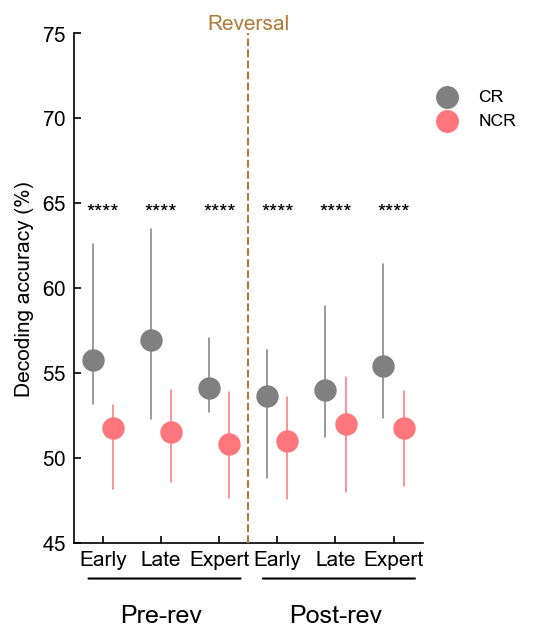

In [36]:
labels = ['Early','Late','Expert','Early','Late','Expert']

fig, ax = plt.subplots(figsize=(3,4.5))
wid = 0.175
    
for idx,(CR_Stim_Dec) in enumerate([passive_CR_Stim_Dec_preearly,passive_CR_Stim_Dec_prelate,passive_CR_Stim_Dec_preexpert,passive_CR_Stim_Dec_postearly,passive_CR_Stim_Dec_postlate,passive_CR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(CR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=CR_COLOR
    border_color=CR_COLOR
    ax.scatter([idx-wid], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx-wid]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')


for idx,(NCR_Stim_Dec) in enumerate([passive_NCR_Stim_Dec_preearly,passive_NCR_Stim_Dec_prelate,passive_NCR_Stim_Dec_preexpert,passive_NCR_Stim_Dec_postearly,passive_NCR_Stim_Dec_postlate,passive_NCR_Stim_Dec_postexpert]):
    Q1, median, Q3 = (np.percentile(ilep.rmnan(NCR_Stim_Dec)*100, q) for q in [25, 50, 75])
    summary_size=100
    summary_width=0.75
    eye_color=NCR_COLOR
    border_color=NCR_COLOR
    ax.scatter([idx+wid], [median], ec=border_color,fc=eye_color, s=summary_size,lw=summary_width, zorder=10)
    ax.plot([idx+wid]*2, [Q1, Q3], c=border_color, lw=summary_width, zorder=9, solid_capstyle='round')

ax.set_xlim([-0.5,5.5])
ax.set_xticks([0,1,2,3,4,5])
ax.set_xticklabels(labels)

ax.set_ylim([45,75])
ax.set_yticks([45,50,55,60,65,70,75])
ax.set_ylabel('Decoding accuracy (%)')

ax.text(0,65,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(1,65,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(2,65,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(3,65,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(4,65,str('****'),verticalalignment='top',horizontalalignment='center')
ax.text(5,65,str('****'),verticalalignment='top',horizontalalignment='center')

xtick_pos_pre = ax.get_xticks()[1]
xtick_pos_post = ax.get_xticks()[4]
Yval = ilep.getPrePostLabelYval(ax.get_ylim())+0.15
t1 = ax.text(xtick_pos_pre, Yval, 'Pre-rev', ha='center', va='top', fontsize=12,color='k')
t2 = ax.text(xtick_pos_post, Yval, 'Post-rev', ha='center', va='top',  fontsize=12,color='k')
ax.annotate('', xy=(0.03, -0.07), xycoords='axes fraction', xytext=(0.49, -0.07),arrowprops=dict(arrowstyle='-', color='black'))
ax.annotate('', xy=(0.53, -0.07), xycoords='axes fraction', xytext=(0.99, -0.07),arrowprops=dict(arrowstyle='-', color='black'))

ax.text(2.5,ax.get_ylim()[1],'Reversal',color=SWITCH_COLOR,horizontalalignment='center',verticalalignment='bottom')
ax.axvline(2.5,color=SWITCH_COLOR,linestyle='--',zorder=10,lw=1)

ax.scatter([],[], ec=CR_COLOR,fc=CR_COLOR, s=100,lw=1, zorder=10,label='CR')
ax.scatter([],[], ec=NCR_COLOR,fc=NCR_COLOR, s=100,lw=1, zorder=10,label='NCR')
lgd = ax.legend(frameon=False,loc=(1,0.8))

fig.savefig(os.path.join('D:\\\\Figures','Manuscript Figures','CR NCR Passive Decoding accuracy V'+str(current_version)+'.pdf'),transparent=False,facecolor="white", bbox_extra_artists=(lgd,t1,t2), bbox_inches='tight')

In [28]:
### Create dataframe ###
phase = len(passive_CR_Stim_Dec_preearly)*["pre-early"] + len(passive_NCR_Stim_Dec_preearly)*["pre-early"] \
    + len(passive_CR_Stim_Dec_prelate)*["pre-late"] + len(passive_NCR_Stim_Dec_prelate)*["pre-late"] \
    + len(passive_CR_Stim_Dec_preexpert)*["pre-expert"] + len(passive_NCR_Stim_Dec_preexpert)*["pre-expert"] \
    + len(passive_CR_Stim_Dec_postearly)*["post-early"] + len(passive_NCR_Stim_Dec_postearly)*["post-early"] \
    + len(passive_CR_Stim_Dec_postlate)*["post-late"] + len(passive_NCR_Stim_Dec_postlate)*["post-late"] \
    + len(passive_CR_Stim_Dec_postexpert)*["post-expert"] + len(passive_NCR_Stim_Dec_postexpert)*["post-expert"]

context = len(passive_CR_Stim_Dec_preearly)*["CR"] + len(passive_NCR_Stim_Dec_preearly)*["NCR"] \
    + len(passive_CR_Stim_Dec_prelate)*["CR"] + len(passive_NCR_Stim_Dec_prelate)*["NCR"] \
    + len(passive_CR_Stim_Dec_preexpert)*["CR"] + len(passive_NCR_Stim_Dec_preexpert)*["NCR"] \
    + len(passive_CR_Stim_Dec_postearly)*["CR"] + len(passive_NCR_Stim_Dec_postearly)*["NCR"] \
    + len(passive_CR_Stim_Dec_postlate)*["CR"] + len(passive_NCR_Stim_Dec_postlate)*["NCR"] \
    + len(passive_CR_Stim_Dec_postexpert)*["CR"] + len(passive_NCR_Stim_Dec_postexpert)*["NCR"]

mod = (np.concatenate([passive_CR_Stim_Dec_preearly, passive_NCR_Stim_Dec_preearly,
    passive_CR_Stim_Dec_prelate, passive_NCR_Stim_Dec_prelate,
    passive_CR_Stim_Dec_preexpert, passive_NCR_Stim_Dec_preexpert,
    passive_CR_Stim_Dec_postearly, passive_NCR_Stim_Dec_postearly,
    passive_CR_Stim_Dec_postlate, passive_NCR_Stim_Dec_postlate,
    passive_CR_Stim_Dec_postexpert, passive_NCR_Stim_Dec_postexpert]))

df = pd.DataFrame({"phase": phase, "context": context, "FR_mod": mod})



### Anova ###
anova = pg.anova(data=df, dv='FR_mod', between=['phase','context'], detailed=True)
print(anova)
print()

### Create and print results ###
pairwise_mwu = pg.pairwise_tests(data=df, dv='FR_mod', between=['phase','context'], padjust="fdr_bh", parametric=False, )
#print(pairwise_mwu[pairwise_mwu["Contrast"] == "phase * context"][["phase","A", "B", "p-unc", "p-corr", "hedges"]])
pairwise_mwu

            Source        SS      DF        MS           F         p-unc  \
0            phase  0.098233     5.0  0.019647    3.801350  2.025972e-03   
1          context  1.188188     1.0  1.188188  229.897339  1.612089e-47   
2  phase * context  0.085570     5.0  0.017114    3.311302  5.644381e-03   
3         Residual  6.005611  1162.0  0.005168         NaN           NaN   

        np2  
0  0.016094  
1  0.165168  
2  0.014048  
3       NaN  



,Contrast,phase,A,B,Paired,Parametric,U-val,alternative,p-unc,p-corr,p-adjust,hedges
0,phase,-,post-early,post-expert,False,False,20960.0,two-sided,1.424503e-03,2.136754e-02,fdr_bh,-0.334963
1,phase,-,post-early,post-late,False,False,9611.0,two-sided,5.595315e-02,1.678595e-01,fdr_bh,-0.224271
2,phase,-,post-early,pre-early,False,False,12094.0,two-sided,4.908739e-02,1.678595e-01,fdr_bh,-0.267481
3,phase,-,post-early,pre-expert,False,False,6775.0,two-sided,3.716146e-01,5.574219e-01,fdr_bh,0.001150
4,phase,-,post-early,pre-late,False,False,11010.0,two-sided,9.659229e-03,7.244422e-02,fdr_bh,-0.329497
5,phase,-,post-expert,post-late,False,False,31838.0,two-sided,3.154620e-01,5.574219e-01,fdr_bh,0.125312
6,phase,-,post-expert,pre-early,False,False,39964.0,two-sided,2.742284e-01,5.574219e-01,fdr_bh,0.054381
7,phase,-,post-expert,pre-expert,False,False,22404.0,two-sided,4.538524e-02,1.678595e-01,fdr_bh,0.342381
8,phase,-,post-expert,pre-late,False,False,36624.0,two-sided,8.139318e-01,8.720698e-01,fdr_bh,-0.007775
9,phase,-,post-late,pre-early,False,False,16304.0,two-sided,9.658691e-01,9.658691e-01,fdr_bh,-0.065239
